In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



In [ ]:
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed_no_chrY.npy')

In [9]:
contact_matrix_zero = f.generate_sample_matrix_bins(1000)

In [10]:
import core.optimizer


best_alpha, best_k, best_clique, final_pval = core.optimizer.optimize_diffusion_params(contact_matrix_zero, 30, (5,100), (0.01, 0.95), n_trials=100)

[I 2025-05-24 17:27:31,181] A new study created in memory with name: no-name-8af56637-b370-4dd3-b5e8-af30f7a2fb99
[I 2025-05-24 17:27:31,553] Trial 0 finished with value: 0.147 and parameters: {'alpha': 0.39794857081266655, 'k': 47}. Best is trial 0 with value: 0.147.
[I 2025-05-24 17:27:32,383] Trial 1 finished with value: 0.41 and parameters: {'alpha': 0.5271746006925309, 'k': 85}. Best is trial 0 with value: 0.147.
[I 2025-05-24 17:27:32,712] Trial 2 finished with value: 0.129 and parameters: {'alpha': 0.5360241204087249, 'k': 45}. Best is trial 2 with value: 0.129.
[I 2025-05-24 17:27:32,972] Trial 3 finished with value: 0.252 and parameters: {'alpha': 0.40251507925835767, 'k': 26}. Best is trial 2 with value: 0.129.
[I 2025-05-24 17:27:33,974] Trial 4 finished with value: 0.449 and parameters: {'alpha': 0.5992002144530385, 'k': 95}. Best is trial 2 with value: 0.129.
[I 2025-05-24 17:27:34,089] Trial 5 finished with value: 0.924 and parameters: {'alpha': 0.06557509446940563, 'k': 

In [11]:
best_alpha, best_k, best_clique, final_pval

(0.8225477429468318,
 32,
 array([30, 71, 32, 87, 61, 42, 47, 52, 80, 64, 89, 78, 72, 79, 45, 40, 10,
        44, 34,  8,  6, 85, 25,  7, 76, 59, 88, 31, 23, 74, 17, 15]),
 0.061)

In [12]:
import core.optimizer
import core.visuals


sizes, ttn_scores, p_values, fold_changes, bg_dists = core.optimizer.optimize_clique_size_diffusion(contact_matrix_zero, max_clique_size=100, seed_bin=30, alpha=best_alpha)

🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 100) ready
✔︎ Built background cliques for all 1000 seeds


Processing sizes: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]

✅ Done optimize_clique_size_analytical


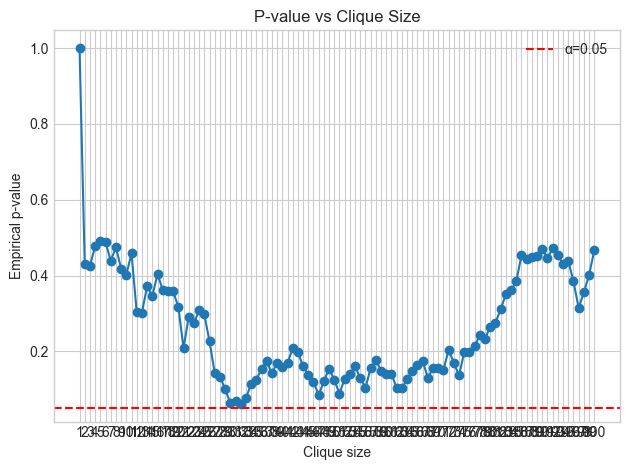

Optimal clique size = 32, p-value = 0.0619


In [13]:
core.visuals.plot_clique_size_optimization(sizes, p_values)